In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


# This notebook is meant to plot $\frac{\Delta C_\ell}{\sigma_\ell}$

The end goal is to be able to reproduce the N5K paper plots also for that, but that's messed up so I'm gonna start with mine, just to have a plot for the casca poster.

In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

In [4]:
include("utils.jl")
using Revise
using .Utils

### Adapting N5K stuff

In [5]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [6]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
Pknonlin = pk_dict["pk_nl"]
k = pk_dict["k"]
z = pk_dict["z"];

In [7]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [8]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm_nl = Interpolations.interpolate(log10.(Pknonlin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm_nl = scale(InterpPmm_nl, x, y)
InterpPmm_nl = Interpolations.extrapolate(InterpPmm_nl, Line());

In [9]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

In [10]:
power_spectrum_nl(k, χ1, χ2) = @. sqrt(10^InterpPmm_nl(z_of_χ(χ1),log10(k)) * 10^InterpPmm_nl(z_of_χ(χ2),log10(k)));

### Loading N5K stuff

In [11]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [12]:
gg = Float32.(benchmark_gg["cls"])
ll = Float32.(benchmark_ll["cls"])
gl = Float32.(benchmark_gl["cls"])
ell = Float32.(benchmark_gg["ls"]);

In [13]:
gg_reshaped = zeros(Float32, length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [14]:
ll_reshaped = zeros(Float32, length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [15]:
gl_reshaped = zeros(Float32, length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in 1:5
        gl_reshaped[:,i,j] = gl[counter, :]
        counter += 1
    end
end

### Interpolate N5K on my grid

In [16]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
nχ = 100
χ = LinRange(26, 7000, nχ)
ℓ = npzread("ell_vector.npy")[1:21];

In [17]:
gg_interp = zeros(21,10,10)
ll_interp = zeros(21,5,5)
gl_interp = zeros(21,10,5)

for i in 1:10
    for j in i:10
        interpol = AkimaInterpolation(gg_reshaped[:,i,j], ell)
        gg_interp[:,i,j] = interpol.(ℓ)
        gg_interp[:,j,i] = gg_interp[:,i,j]
    end
end

for i in 1:5
    for j in i:5
        interpol = AkimaInterpolation(ll_reshaped[:,i,j], ell)
        ll_interp[:,i,j] = interpol.(ℓ)
        ll_interp[:,j,i] = ll_interp[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = AkimaInterpolation(gl_reshaped[:,i,j], ell)
        gl_interp[:,i,j] = interpol.(ℓ)
    end
end

# Load your best $\tilde T$ here!

For now it's the 75+150, $\alpha = 0.9$

In [18]:
R = unique(vcat(LinRange(0,0.8,76)[2:end], LinRange(0.8,1,451)))
nR = length(R)
coeff = zeros(nχ,nR,n_cheb+1)

for i in 1:nR
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*R[i]), log10(kmin), log10(kmax)); 
        coeff[j,i,:] = c.coefs
    end
end

In [19]:
T_LL = load_Ts("Ts_4_real/T_tilde_LL_75+450", nχ, nR)
T_CL = load_Ts("Ts_4_real/T_tilde_CL_75+450", nχ, nR)
T_CC = load_Ts("Ts_4_real/T_tilde_CC_75+450", nχ, nR)


w_LL = Float32.(Will.w_ell_tullio(coeff, T_LL))
w_CL = Float32.(Will.w_ell_tullio(coeff, T_CL))
w_CC = Float32.(Will.w_ell_tullio(coeff, T_CC));

# $C_\ell$ computation 

In [20]:
Cℓ_CC_limb_lin = Float32.(npzread("Cl_CC_limber_linear.npy"))
Cℓ_CL_limb_lin = Float32.(npzread("Cl_CL_limber_linear.npy"))
Cℓ_LL_limb_lin = Float32.(npzread("Cl_LL_limber_linear.npy"));

In [21]:
Cℓ_CC_limb_nl = Float32.(npzread("Cl_CC_limber_nl.npy"))
Cℓ_CL_limb_nl = Float32.(npzread("Cl_CL_limber_nl.npy"))
Cℓ_LL_limb_nl = Float32.(npzread("Cl_LL_limber_nl.npy"));

In [22]:
@time σ_CC, σ_LL, σ_CL = cosmic_variance(gg_reshaped, ll_reshaped, gl_reshaped, ell, 0.4);

┌ Warning: #= /Users/sofiachiarenza/.julia/packages/Tullio/vChiX/src/macro.jl:1093 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main.Utils ~/.julia/packages/LoopVectorization/7gWfp/src/condense_loopset.jl:1148
┌ Warning: #= /Users/sofiachiarenza/.julia/packages/Tullio/vChiX/src/macro.jl:1093 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ Main.Utils ~/.julia/packages/LoopVectorization/7gWfp/src/condense_loopset.jl:1148


  2.928276 seconds (9.43 M allocations: 1.764 GiB, 4.50% gc time, 99.80% compilation time)


In [23]:
σ_CC, σ_LL, σ_CL = Float32.(σ_CC), Float32.(σ_LL), Float32.(σ_CL);

In [24]:
W = npzread("../N5K/input/kernels_fullwidth.npz")
@time K_CC, K_CL, K_LL = compute_kernels(W, χ, R);

  2.208884 seconds (8.24 M allocations: 1.078 GiB, 6.18% gc time, 98.38% compilation time)


In [25]:
K_CC, K_CL, K_LL = Float32.(K_CC), Float32.(K_CL), Float32.(K_LL);

In [28]:
Cℓ_CC = Float32.(C_ell_computation_simpson_uneven_grid(w_CC, K_CC, χ,75, 450, 0.8));
Cℓ_CL = Float32.(C_ell_computation_simpson_uneven_grid(w_CL, K_CL, χ,75, 450, 0.8));
Cℓ_LL = Float32.(C_ell_computation_simpson_uneven_grid(w_LL, K_LL, χ,75, 450, 0.8));

In [29]:
# ADDING ELL PREFACTORS
Cℓ_CC = Cℓ_CC .* Float32((2/π))

for i in 1:length(ℓ)
    Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* Float32(factorial_frac(ℓ[i]) ./ π)
    Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* Float32(sqrt.(factorial_frac(ℓ[i])) ./ π)
end

In [30]:
final_Cℓ_CC = Cℓ_CC + Float32.(Cℓ_CC_limb_nl) - Float32.(Cℓ_CC_limb_lin)
final_Cℓ_CL = Cℓ_CL + Float32.(Cℓ_CL_limb_nl) - Float32.(Cℓ_CL_limb_lin)
final_Cℓ_LL = Cℓ_LL + Float32.(Cℓ_LL_limb_nl) - Float32.(Cℓ_LL_limb_lin);

# New part

I need to compute my $C_\ell$'s on all the chebyshev points up to 3000. After the first 21 points, which are the one that i have, I can just use the Limber approximation!

In [31]:
Cℓ_CC_limb = Float32.(npzread("Cl_CC_limber.npy"))
Cℓ_CL_limb = Float32.(npzread("Cl_CL_limber.npy"))
Cℓ_LL_limb = Float32.(npzread("Cl_LL_limber.npy"));

In [32]:
total_Cℓ_CC = cat(final_Cℓ_CC, Cℓ_CC_limb, dims=1)
total_Cℓ_CL = cat(final_Cℓ_CL, Cℓ_CL_limb, dims=1)
total_Cℓ_LL = cat(final_Cℓ_LL, Cℓ_LL_limb, dims=1);

Now, interpolate!

In [33]:
elle = Float32.(reverse(chebpoints(100, 2, 3000)))
ℓ_min = 2
ℓ_max = 3000

interp_Cℓ_CC = zeros(Float32, length(ell), 10, 10)
interp_Cℓ_CL = zeros(Float32, length(ell), 10, 5)
interp_Cℓ_LL = zeros(Float32, length(ell), 5, 5)

for i in 1:10
    for j in i:10
        interpol = chebinterp(reverse(elle.*elle.*total_Cℓ_CC[:,i,j]), ℓ_min, ℓ_max)
        interp_Cℓ_CC[:,i,j] = interpol.(ell)./(ell.*ell)
        interp_Cℓ_CC[:,j,i] = interp_Cℓ_CC[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = chebinterp(reverse(elle.*elle.*total_Cℓ_CL[:,i,j]),ℓ_min, ℓ_max)
        interp_Cℓ_CL[:,i,j] = interpol.(ell)./(ell.*ell)
    end
end

for i in 1:5
    for j in i:5
        interpol = chebinterp(reverse(elle.*elle.*total_Cℓ_LL[:,i,j]), ℓ_min, ℓ_max)
        interp_Cℓ_LL[:,i,j] = interpol.(ell)./(ell.*ell)
        interp_Cℓ_LL[:,j,i] = interp_Cℓ_LL[:,i,j]
    end
end

In [34]:
@time begin 
    m_CC = MAER(interp_Cℓ_CC, gg_reshaped, σ_CC)
    m_LL = MAER(interp_Cℓ_LL, ll_reshaped, σ_LL)
    m_CL = MAER(interp_Cℓ_CL, gl_reshaped, σ_CL)
end;

  0.689025 seconds (1.86 M allocations: 104.103 MiB, 1.03% gc time, 99.99% compilation time)


In [35]:
npzwrite("m_CC_F32.npy", m_CC)
npzwrite("m_LL_F32.npy", m_LL)
npzwrite("m_CL_F32.npy", m_CL)

### FANG 

In [36]:
# Load the .npz file
fang = npzread("/Users/sofiachiarenza/Desktop/PhD_Stuff/N5K/tests/ccl_nonlim_fang_clgs.npz")

fang_cl_gs = fang["cls"]
fang_gs_reshaped = zeros(length(ell), 10, 5)

counter = 1

for i in 1:10
    for j in 1:5
        fang_gs_reshaped[:, i, j] = fang_cl_gs[counter, :]
        counter += 1
    end
end

fang = npzread("/Users/sofiachiarenza/Desktop/PhD_Stuff/N5K/tests/ccl_nonlim_fang_clgg.npz")

fang_cl_gg = fang["cls"]
fang_gg_reshaped = zeros(length(ell), 10, 10)

counter = 1

for i in 1:10
    for j in i:10
        fang_gg_reshaped[:, i, j] = fang_cl_gg[counter, :]
        fang_gg_reshaped[:, j, i] = fang_gg_reshaped[:, i, j]
        counter += 1
    end
end

fang = npzread("/Users/sofiachiarenza/Desktop/PhD_Stuff/N5K/tests/ccl_nonlim_fang_clss.npz")

fang_cl_ss = fang["cls"]
fang_ss_reshaped = zeros(length(ell), 5, 5)

counter = 1

for i in 1:5
    for j in i:5
        fang_ss_reshaped[:, i, j] = fang_cl_ss[counter, :]
        fang_ss_reshaped[:, j, i] = fang_ss_reshaped[:, i, j]
        counter += 1
    end
end

In [37]:
@time begin 
    m_CC_fang = MAER(fang_gg_reshaped, gg_reshaped, σ_CC)
    m_LL_fang = MAER(fang_ss_reshaped, ll_reshaped, σ_LL)
    m_CL_fang = MAER(fang_gs_reshaped, gl_reshaped, σ_CL)
end;

  0.527150 seconds (1.83 M allocations: 101.935 MiB, 2.39% gc time, 99.99% compilation time)


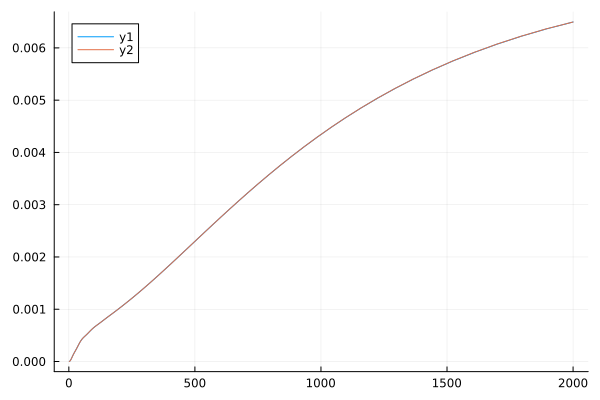

In [38]:
plot(ell, ell .* (ell .+1 ) .*fang_gs_reshaped[:,1,1])
plot!(ell, ell .* (ell .+1 ) .*gl_reshaped[:,1,1])

In [39]:
total_limb_CL = cat(Cℓ_CL_limb_nl,Cℓ_CL_limb,dims=1)
total_limb_LL = cat(Cℓ_LL_limb_nl,Cℓ_LL_limb,dims=1)
total_limb_CC = cat(Cℓ_CC_limb_nl,Cℓ_CC_limb,dims=1);

In [40]:
int_limb_CC = zeros(length(ell), 10, 10)
int_limb_CL = zeros(length(ell), 10, 5)
int_limb_LL = zeros(length(ell), 5, 5)

for i in 1:10
    for j in i:10
        interpol = chebinterp(reverse(elle.*elle.*total_limb_CC[:,i,j]), ℓ_min, ℓ_max)
        int_limb_CC[:,i,j] = interpol.(ell)./(ell.*ell)
        int_limb_CC[:,j,i] = int_limb_CC[:,i,j]
    end
end

for i in 1:10
    for j in 1:5
        interpol = chebinterp(reverse(elle.*elle.*total_limb_CL[:,i,j]),ℓ_min, ℓ_max)
        int_limb_CL[:,i,j] = interpol.(ell)./(ell.*ell)
    end
end

for i in 1:5
    for j in i:5
        interpol = chebinterp(reverse(elle.*elle.*total_limb_LL[:,i,j]), ℓ_min, ℓ_max)
        int_limb_LL[:,i,j] = interpol.(ell)./(ell.*ell)
        int_limb_LL[:,j,i] = int_limb_LL[:,i,j]
    end
end

In [41]:
@time begin 
    m_CC_limb = MAER(int_limb_CC, gg_reshaped, σ_CC)
    m_LL_limb = MAER(int_limb_LL, ll_reshaped, σ_LL)
    m_CL_limb = MAER(int_limb_CL, gl_reshaped, σ_CL)
end;

  0.000055 seconds (6 allocations: 141.062 KiB)
